#Project: Spark Sherlock
#Name: Vidhi Ashok Palan, Pooja, Pratik Kale

In [0]:
import mlflow
import mlflow.spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
df = spark.read.csv("/FileStore/tables/Synthetic_Financial_datasets_log.csv", header=True, inferSchema=True)


In [0]:
print("Number of rows:", df.count())
df.printSchema()


Number of rows: 6362620
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [0]:
df.groupBy("isFraud").count().show()
df.groupBy("isFlaggedFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+

+--------------+-------+
|isFlaggedFraud|  count|
+--------------+-------+
|             0|6362604|
|             1|     16|
+--------------+-------+



In [0]:
df_new = df.drop("nameOrig", "nameDest", "isFlaggedFraud", "step")


In [0]:
df_new = df_new.withColumn("deltaOrig", col("oldbalanceOrg") - col("newbalanceOrig")) \
               .withColumn("deltaDest", col("newbalanceDest") - col("oldbalanceDest")) \
               .withColumn("amount_to_orig_ratio", col("amount") / (col("oldbalanceOrg") + 1)) \
               .withColumn("amount_to_dest_ratio", col("amount") / (col("oldbalanceDest") + 1))


In [0]:
indexer = StringIndexer(inputCol="type", outputCol="type_indexed", handleInvalid="keep")
df_new = indexer.fit(df_new).transform(df_new)

In [0]:
encoder = OneHotEncoder(inputCols=["type_indexed"], outputCols=["type_vec"])
df_new = encoder.fit(df_new).transform(df_new)

# Check columns
df_new.select("isFraud", "type", "type_indexed", "type_vec").show(5)
df_new.columns

+-------+--------+------------+-------------+
|isFraud|    type|type_indexed|     type_vec|
+-------+--------+------------+-------------+
|      0| PAYMENT|         1.0|(5,[1],[1.0])|
|      0| PAYMENT|         1.0|(5,[1],[1.0])|
|      1|TRANSFER|         3.0|(5,[3],[1.0])|
|      1|CASH_OUT|         0.0|(5,[0],[1.0])|
|      0| PAYMENT|         1.0|(5,[1],[1.0])|
+-------+--------+------------+-------------+
only showing top 5 rows

Out[14]: ['type',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'deltaOrig',
 'deltaDest',
 'amount_to_orig_ratio',
 'amount_to_dest_ratio',
 'type_indexed',
 'type_vec']

#Data Balance

In [0]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'deltaOrig', 'deltaDest', 'amount_to_orig_ratio', 'amount_to_dest_ratio',
    'type_vec'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_final = assembler.transform(df_new)


In [0]:
df_final.select("isFraud", "features").show(5)


+-------+--------------------+
|isFraud|            features|
+-------+--------------------+
|      0|(14,[0,1,2,5,7,8,...|
|      0|(14,[0,1,2,5,7,8,...|
|      1|(14,[0,1,5,7,8,12...|
|      1|(14,[0,1,3,5,6,7,...|
|      0|(14,[0,1,2,5,7,8,...|
+-------+--------------------+
only showing top 5 rows



In [0]:
total = df_final.count()
fraud_count = df_final.filter(col("isFraud") == 1).count()
non_fraud_count = df_final.filter(col("isFraud") == 0).count()

fraud_weight = total / (2 * fraud_count)
non_fraud_weight = total / (2 * non_fraud_count)

print(f"Fraud weight: {fraud_weight}, Non-fraud weight: {non_fraud_weight}")


Fraud weight: 387.35054182393765, Non-fraud weight: 0.5006462444095885


In [0]:
from pyspark.sql.functions import when

df_weighted = df_final.withColumn(
    "classWeightCol",
    when(col("isFraud") == 1, fraud_weight).otherwise(non_fraud_weight)
)


In [0]:
df_weighted.select("isFraud", "classWeightCol").groupBy("isFraud", "classWeightCol").count().show()


+-------+------------------+-------+
|isFraud|    classWeightCol|  count|
+-------+------------------+-------+
|      1|387.35054182393765|   8213|
|      0|0.5006462444095885|6354407|
+-------+------------------+-------+



#Dataset is balanced logically
Model Implementation using 50% of data -> Logistic Regression

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
import mlflow
import mlflow.spark
df_50 = df_weighted.sample(withReplacement=False, fraction=0.5, seed=42)


In [0]:
with mlflow.start_run(run_name="LogReg_Weighted_50Percent"):

    # Define the model
    lr = LogisticRegression(
        featuresCol="features",
        labelCol="isFraud",
        weightCol="classWeightCol",
        maxIter=10
    )
model_50 = lr.fit(df_50)

predictions_50 = model_50.transform(df_50)

In [0]:
pred_pd = predictions_50.select("isFraud", "prediction").toPandas()
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# True and predicted values
y_true = pred_pd["isFraud"]
y_pred = pred_pd["prediction"]

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {acc:.4f}")


📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8801    0.9362   3178413
           1     0.0105    0.9875    0.0208      4092

    accuracy                         0.8802   3182505
   macro avg     0.5052    0.9338    0.4785   3182505
weighted avg     0.9987    0.8802    0.9350   3182505

✅ Accuracy: 0.8802


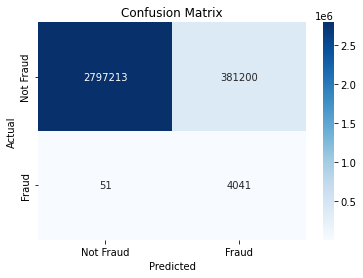

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Model Implementation using 70% of data -> Logistic Regression

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import mlflow
import mlflow.spark
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df_70 = df_weighted.sample(withReplacement=False, fraction=0.7, seed=42)
with mlflow.start_run(run_name="LogReg_Weighted_70Percent"):
    lr = LogisticRegression(
        featuresCol="features",
        labelCol="isFraud",
        weightCol="classWeightCol",
        maxIter=10
    )
model_70 = lr.fit(df_70)
predictions_70 = model_70.transform(df_70)

✅ Accuracy: 0.9052
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9051    0.9502   4448483
           1     0.0128    0.9564    0.0252      5707

    accuracy                         0.9052   4454190
   macro avg     0.5064    0.9307    0.4877   4454190
weighted avg     0.9987    0.9052    0.9490   4454190



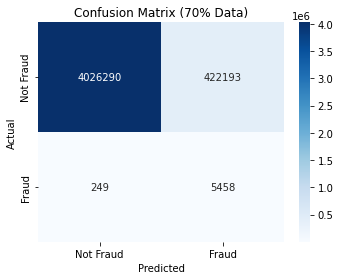

In [0]:
pred_pd = predictions_70.select("isFraud", "prediction").toPandas()
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_true = pred_pd["isFraud"]
y_pred = pred_pd["prediction"]

acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {acc:.4f}")
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix (70% Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#Model Implementation using 85% of data -> Logistic Regression

✅ Accuracy: 0.8594
📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8592    0.9243   5400770
           1     0.0089    0.9774    0.0176      6976

    accuracy                         0.8594   5407746
   macro avg     0.5044    0.9183    0.4709   5407746
weighted avg     0.9987    0.8594    0.9231   5407746



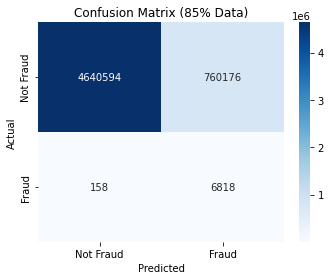

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
df_85 = df_weighted.sample(withReplacement=False, fraction=0.85, seed=42)
lr = LogisticRegression(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="classWeightCol",
    maxIter=10
)

model_85 = lr.fit(df_85)
predictions_85 = model_85.transform(df_85)
pred_pd = predictions_85.select("isFraud", "prediction").toPandas()
y_true = pred_pd["isFraud"]
y_pred = pred_pd["prediction"]
acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {acc:.4f}")
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix (85% Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Model Implementation - Random Forest using 50% of data

✅ Accuracy: 1.0000
📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   3178413
           1     0.9862    0.9990    0.9926      4092

    accuracy                         1.0000   3182505
   macro avg     0.9931    0.9995    0.9963   3182505
weighted avg     1.0000    1.0000    1.0000   3182505



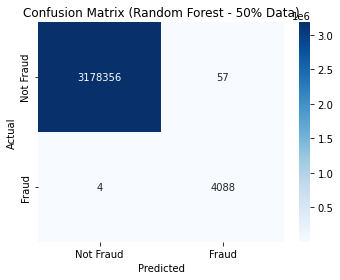

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
#used 50% of data
df_50 = df_weighted.sample(withReplacement=False, fraction=0.5, seed=42)
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="classWeightCol",
    numTrees=100,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(df_50)
predictions_50 = rf_model.transform(df_50)

pred_pd = predictions_50.select("isFraud", "prediction").toPandas()
y_true = pred_pd["isFraud"]
y_pred = pred_pd["prediction"]
acc = accuracy_score(y_true, y_pred)
#Accuracy Score and Classification report
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix (Random Forest - 50% Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Model Implementation - Random Forest using 70% of data

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   4448483
           1     0.9801    0.9991    0.9895      5707

    accuracy                         1.0000   4454190
   macro avg     0.9900    0.9995    0.9947   4454190
weighted avg     1.0000    1.0000    1.0000   4454190



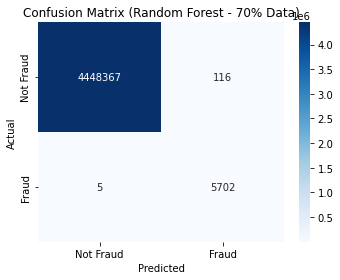

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#Used 70% of data
df_70 = df_weighted.sample(withReplacement=False, fraction=0.7, seed=42)
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="classWeightCol",
    numTrees=100,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(df_70)

#Make predictions
predictions_70 = rf_model.transform(df_70)
pred_pd = predictions_70.select("isFraud", "prediction").toPandas()
y_true = pred_pd["isFraud"]
y_pred = pred_pd["prediction"]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix (Random Forest - 70% Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Model Implementation - Random Forest using 85% of data

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   5400770
           1     0.9886    0.9983    0.9934      6976

    accuracy                         1.0000   5407746
   macro avg     0.9943    0.9991    0.9967   5407746
weighted avg     1.0000    1.0000    1.0000   5407746



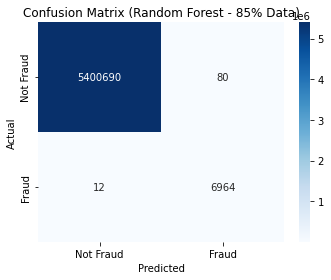

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Used 85% of dataset
df_85 = df_weighted.sample(withReplacement=False, fraction=0.85, seed=42)
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="classWeightCol",
    numTrees=100,
    maxDepth=10,
    seed=42
)
rf_model = rf.fit(df_85)

#Make predictions
predictions_85 = rf_model.transform(df_85)
pred_pd = predictions_85.select("isFraud", "prediction").toPandas()
y_true = pred_pd["isFraud"]
y_pred = pred_pd["prediction"]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix (Random Forest - 85% Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Running model again with Stratify technique

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import time

# 1) Load raw data
raw = spark.read.csv("/FileStore/tables/Synthetic_Financial_datasets_log.csv",
                     header=True, inferSchema=True)

# 2) Preprocess & feature‐engineering
df = (raw
      .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
      .withColumn("deltaOrig", col("oldbalanceOrg") - col("newbalanceOrig"))
      .withColumn("deltaDest", col("newbalanceDest") - col("oldbalanceDest"))
      .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
      .withColumn("amount_to_dest_ratio",  col("amount")/(col("oldbalanceDest")+1))
     )

# index + one‐hot your “type” column
si = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
df = si.fit(df).transform(df)
ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
df = ohe.fit(df).transform(df)

# 3) Stratified 50% sample then 80/20 train/test split
sample = df.stat.sampleBy("isFraud", {0:0.5, 1:0.5}, seed=2025)
train = sample.stat.sampleBy("isFraud", {0:0.8, 1:0.8}, seed=2025)
# (we’ll re‐derive test in Cell 2)

# 4) Build pipeline
feature_cols = [
    'amount','oldbalanceOrg','newbalanceOrig',
    'oldbalanceDest','newbalanceDest',
    'deltaOrig','deltaDest',
    'amount_to_orig_ratio','amount_to_dest_ratio',
    'type_vec'
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
scaler    = StandardScaler(inputCol="rawFeatures", outputCol="features",
                            withStd=True, withMean=False)

# compute class‐weights
total = train.count()
frauds = train.filter(col("isFraud")==1).count()
w = 1.0/(frauds/total)
train = train.withColumn("weight",
                         when(col("isFraud")==1, w).otherwise(1.0))

rf = RandomForestClassifier(labelCol="isFraud",
                            featuresCol="features",
                            weightCol="weight",
                            numTrees=100, maxDepth=8, seed=42)

pipeline = Pipeline(stages=[assembler, scaler, rf])

# 5) Train & time
start = time.time()
model = pipeline.fit(train)
print(f"50% sample — TRAIN TIME: {time.time()-start:.2f} sec")

# 6) Save model to DBFS
model.write().overwrite().save("dbfs:/FileStore/models/rf_50pct_model")


50% sample — TRAIN TIME: 854.10 sec


In [0]:
from pyspark.ml import PipelineModel
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import when, col
from pyspark.mllib.evaluation import MulticlassMetrics

# 1) Reload the saved pipeline
model = PipelineModel.load("dbfs:/FileStore/models/rf_50pct_model")

# 2) Re‐create the same 50% sample & 80/20 split to get your test set
raw = spark.read.csv("/FileStore/tables/Synthetic_Financial_datasets_log.csv",
                     header=True, inferSchema=True)

df = (raw
      .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
      .withColumn("deltaOrig", col("oldbalanceOrg") - col("newbalanceOrig"))
      .withColumn("deltaDest", col("newbalanceDest") - col("oldbalanceDest"))
      .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
      .withColumn("amount_to_dest_ratio", col("amount")/(col("oldbalanceDest")+1))
     )

si  = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
df  = si.fit(df).transform(df)
ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
df  = ohe.fit(df).transform(df)

sample = df.stat.sampleBy("isFraud", {0:0.5, 1:0.5}, seed=2025)
train  = sample.stat.sampleBy("isFraud", {0:0.8, 1:0.8}, seed=2025)
test   = sample.subtract(train)

# 3) Run prediction, converting vector → array then threshold
preds = (
    model.transform(test)
         .withColumn("prob_arr", vector_to_array(col("probability")))
         .withColumn("pred_label", when(col("prob_arr")[1] > 0.1, 1).otherwise(0))
)

# 4) Build RDD & metrics
pred_and_lbl = preds.select("pred_label","isFraud") \
                    .rdd.map(lambda r: (float(r[0]), float(r[1])))
metrics = MulticlassMetrics(pred_and_lbl)

# Overall accuracy
accuracy = metrics.accuracy
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("=== Confusion Matrix ===")
print(metrics.confusionMatrix().toArray())

# Classification report
#  Extract distinct labels from the RDD
labels = sorted(pred_and_lbl.map(lambda x: x[1]).distinct().collect())

#  Support counts
support_counts = dict(
    test.groupBy("isFraud").count().rdd
        .map(lambda r: (float(r[0]), r[1]))
        .collect()
)

print("\n=== Classification Report ===")
for label in labels:
    precision = metrics.precision(label)
    recall    = metrics.recall(label)
    f1        = metrics.fMeasure(label)
    support   = support_counts.get(label, 0)
    print(f"Class {int(label)} — "
          f"precision: {precision:.4f}, "
          f"recall:    {recall:.4f}, "
          f"f1-score:  {f1:.4f}, "
          f"support:   {support}")


Accuracy: 0.9975
=== Confusion Matrix ===
[[624662.   1565.]
 [     0.    843.]]

=== Classification Report ===
Class 0 — precision: 1.0000, recall:    0.9975, f1-score:  0.9987, support:   626227
Class 1 — precision: 0.3501, recall:    1.0000, f1-score:  0.5186, support:   843


In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import time

# 1) Load raw data
raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True,
    inferSchema=True
)

# 2) Preprocess & feature engineering
df = (raw
      .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
      .withColumn("deltaOrig", col("oldbalanceOrg") - col("newbalanceOrig"))
      .withColumn("deltaDest", col("newbalanceDest") - col("oldbalanceDest"))
      .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
      .withColumn("amount_to_dest_ratio", col("amount")/(col("oldbalanceDest")+1))
)

# index + one-hot encode 'type'
si  = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
df  = si.fit(df).transform(df)
ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
df  = ohe.fit(df).transform(df)

# 3) Stratified 30% sample then 80/20 train/test split
sample = df.stat.sampleBy("isFraud", {0: 0.3, 1: 0.3}, seed=2025)
train  = sample.stat.sampleBy("isFraud", {0: 0.8, 1: 0.8}, seed=2025)
# (test split reserved for Cell 2)

# 4) Assemble features & scale
toolkit = VectorAssembler(inputCols=[
    'amount','oldbalanceOrg','newbalanceOrig',
    'oldbalanceDest','newbalanceDest',
    'deltaOrig','deltaDest',
    'amount_to_orig_ratio','amount_to_dest_ratio',
    'type_vec'
], outputCol="rawFeatures")
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features",
                        withStd=True, withMean=False)

# 5) Compute class weights on training set
total   = train.count()
frauds  = train.filter(col("isFraud")==1).count()
weight  = 1.0/(frauds/total)
train   = train.withColumn("weight", when(col("isFraud")==1, weight).otherwise(1.0))

# 6) Random Forest classifier
rf = RandomForestClassifier(
    labelCol="isFraud",
    featuresCol="features",
    weightCol="weight",
    numTrees=100,
    maxDepth=8,
    seed=42
)
pipeline = Pipeline(stages=[toolkit, scaler, rf])

# 7) Train & time
start = time.time()
model = pipeline.fit(train)
print(f"30% sample — TRAIN TIME: {time.time()-start:.2f} sec")

# 8) Save model to DBFS
model.write().overwrite().save("dbfs:/FileStore/models/rf_30pct_model")

30% sample — TRAIN TIME: 534.85 sec


In [0]:
from pyspark.ml import PipelineModel
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import when, col
from pyspark.mllib.evaluation import MulticlassMetrics

# 1) Reload the saved pipeline
model = PipelineModel.load("dbfs:/FileStore/models/rf_30pct_model")

# 2) Re‐create the same sample & split to get your test set
raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True, inferSchema=True
)

df = (raw
      .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
      .withColumn("deltaOrig",    col("oldbalanceOrg") - col("newbalanceOrig"))
      .withColumn("deltaDest",    col("newbalanceDest") - col("oldbalanceDest"))
      .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
      .withColumn("amount_to_dest_ratio",  col("amount")/(col("oldbalanceDest")+1))
)
si  = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
df  = si.fit(df).transform(df)
ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
df  = ohe.fit(df).transform(df)

sample = df.stat.sampleBy("isFraud", {0: 0.3, 1: 0.3}, seed=2025)
train  = sample.stat.sampleBy("isFraud", {0: 0.8, 1: 0.8}, seed=2025)
test   = sample.subtract(train)

# 3) Predict, convert vector→array then threshold
preds = (
    model.transform(test)
         .withColumn("prob_arr", vector_to_array(col("probability")))
         .withColumn("pred_label", when(col("prob_arr")[1] > 0.1, 1).otherwise(0))
)

# 4) Compute metrics
rdd     = preds.select("pred_label", "isFraud") \
               .rdd.map(lambda r: (float(r[0]), float(r[1])))
metrics = MulticlassMetrics(rdd)

# Overall accuracy
print(f"Accuracy: {metrics.accuracy:.4f}")

# Confusion matrix
print("=== Confusion Matrix ===")
print(metrics.confusionMatrix().toArray())

# Classification report
labels = sorted(rdd.map(lambda x: x[1]).distinct().collect())
support = dict(test.groupBy("isFraud").count()
                   .rdd.map(lambda r: (float(r[0]), r[1]))
                   .collect())

print("\n=== Classification Report ===")
for lbl in labels:
    print(
        f"Class {int(lbl)} — precision: {metrics.precision(lbl):.4f}, "
        f"recall: {metrics.recall(lbl):.4f}, "
        f"f1-score: {metrics.fMeasure(lbl):.4f}, "
        f"support: {support.get(lbl,0)}"
    )


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.9984
=== Confusion Matrix ===
[[377103.    589.]
 [     0.    506.]]

=== Classification Report ===
Class 0 — precision: 1.0000, recall: 0.9984, f1-score: 0.9992, support: 377692
Class 1 — precision: 0.4621, recall: 1.0000, f1-score: 0.6321, support: 506


In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import time

# 1) Load raw data
raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True, inferSchema=True
)

# 2) Preprocess & feature engineering
df = (raw
      .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
      .withColumn("deltaOrig",    col("oldbalanceOrg") - col("newbalanceOrig"))
      .withColumn("deltaDest",    col("newbalanceDest") - col("oldbalanceDest"))
      .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
      .withColumn("amount_to_dest_ratio",  col("amount")/(col("oldbalanceDest")+1))
)

# index + one-hot encode 'type'
si  = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
df  = si.fit(df).transform(df)
ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
df  = ohe.fit(df).transform(df)

# 3) Stratified 75% sample then 80/20 train/test split
sample = df.stat.sampleBy("isFraud", {0: 0.75, 1: 0.75}, seed=2025)
train  = sample.stat.sampleBy("isFraud", {0: 0.8, 1: 0.8}, seed=2025)
# (test split reserved for Cell 2)

# 4) Assemble features & scale
assembler = VectorAssembler(inputCols=[
    'amount','oldbalanceOrg','newbalanceOrig',
    'oldbalanceDest','newbalanceDest',
    'deltaOrig','deltaDest',
    'amount_to_orig_ratio','amount_to_dest_ratio',
    'type_vec'
], outputCol="rawFeatures")
scaler    = StandardScaler(inputCol="rawFeatures", outputCol="features",
                           withStd=True, withMean=False)

# 5) Compute class weights on training set
total  = train.count()
frauds = train.filter(col("isFraud") == 1).count()
w      = 1.0 / (frauds / total)
train  = train.withColumn("weight", when(col("isFraud") == 1, w).otherwise(1.0))

# 6) Random Forest classifier
rf = RandomForestClassifier(
    labelCol="isFraud",
    featuresCol="features",
    weightCol="weight",
    numTrees=100,
    maxDepth=8,
    seed=42
)
pipeline = Pipeline(stages=[assembler, scaler, rf])

# 7) Train & time
start = time.time()
model = pipeline.fit(train)
print(f"75% sample — TRAIN TIME: {time.time() - start:.2f} sec")

# 8) Save model to DBFS
model.write().overwrite().save("dbfs:/FileStore/models/rf_75pct_model")


75% sample — TRAIN TIME: 1152.32 sec


In [0]:
from pyspark.ml import PipelineModel
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import when, col
from pyspark.mllib.evaluation import MulticlassMetrics

# 1) Reload the saved pipeline
model = PipelineModel.load("dbfs:/FileStore/models/rf_75pct_model")

# 2) Re-create the same 75% sample & 80/20 split to get your test set
raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True, inferSchema=True
)

df = (raw
      .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
      .withColumn("deltaOrig",    col("oldbalanceOrg") - col("newbalanceOrig"))
      .withColumn("deltaDest",    col("newbalanceDest") - col("oldbalanceDest"))
      .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
      .withColumn("amount_to_dest_ratio",  col("amount")/(col("oldbalanceDest")+1))
)
si  = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
df  = si.fit(df).transform(df)
ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
df  = ohe.fit(df).transform(df)

sample = df.stat.sampleBy("isFraud", {0: 0.75, 1: 0.75}, seed=2025)
train  = sample.stat.sampleBy("isFraud", {0: 0.8, 1: 0.8}, seed=2025)
test   = sample.subtract(train)

# 3) Predict, convert vector→array then threshold
preds = (
    model.transform(test)
         .withColumn("prob_arr", vector_to_array(col("probability")))
         .withColumn("pred_label", when(col("prob_arr")[1] > 0.1, 1).otherwise(0))
)

# 4) Compute metrics
rdd     = preds.select("pred_label", "isFraud") \
               .rdd.map(lambda r: (float(r[0]), float(r[1])))
metrics = MulticlassMetrics(rdd)

# Overall accuracy
print(f"Accuracy: {metrics.accuracy:.4f}")

# Confusion matrix
print("=== Confusion Matrix ===")
print(metrics.confusionMatrix().toArray())

# Classification report
labels  = sorted(rdd.map(lambda x: x[1]).distinct().collect())
support = dict(test.groupBy("isFraud").count()
                   .rdd.map(lambda r: (float(r[0]), r[1]))
                   .collect())

print("\n=== Classification Report ===")
for lbl in labels:
    print(f"Class {int(lbl)} — "
          f"precision: {metrics.precision(lbl):.4f}, "
          f"recall:    {metrics.recall(lbl):.4f}, "
          f"f1-score:  {metrics.fMeasure(lbl):.4f}, "
          f"support:   {support.get(lbl,0)}")


Accuracy: 0.9970
=== Confusion Matrix ===
[[931057.   2763.]
 [     0.   1187.]]

=== Classification Report ===
Class 0 — precision: 1.0000, recall:    0.9970, f1-score:  0.9985, support:   933820
Class 1 — precision: 0.3005, recall:    1.0000, f1-score:  0.4621, support:   1187


In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import time

# 1) Load raw data
raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True, inferSchema=True
)

# 2) Preprocess & feature engineering
df = (raw
      .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
      .withColumn("deltaOrig",    col("oldbalanceOrg") - col("newbalanceOrig"))
      .withColumn("deltaDest",    col("newbalanceDest") - col("oldbalanceDest"))
      .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
      .withColumn("amount_to_dest_ratio",  col("amount")/(col("oldbalanceDest")+1))
)
# index & encode 'type'
si  = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
df  = si.fit(df).transform(df)
ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
df  = ohe.fit(df).transform(df)

# 3) Stratified 90% sample then 80/20 split
sample = df.stat.sampleBy("isFraud", {0:0.9, 1:0.9}, seed=2025)
train  = sample.stat.sampleBy("isFraud", {0:0.8, 1:0.8}, seed=2025)
# 4) Assemble & scale
assembler = VectorAssembler(inputCols=[
    'amount','oldbalanceOrg','newbalanceOrig',
    'oldbalanceDest','newbalanceDest',
    'deltaOrig','deltaDest',
    'amount_to_orig_ratio','amount_to_dest_ratio',
    'type_vec'
], outputCol="rawFeatures")
scaler    = StandardScaler(inputCol="rawFeatures", outputCol="features",
                            withStd=True, withMean=False)

# 5) Compute class weights
total  = train.count()
frauds = train.filter(col("isFraud")==1).count()
w      = 1.0/(frauds/total)
train  = train.withColumn("weight", when(col("isFraud")==1, w).otherwise(1.0))

# 6) RF classifier
rf = RandomForestClassifier(
    labelCol="isFraud", featuresCol="features", weightCol="weight",
    numTrees=100, maxDepth=8, seed=42
)
pipeline = Pipeline(stages=[assembler, scaler, rf])

# 7) Train & time
start = time.time()
model = pipeline.fit(train)
print(f"90% sample — TRAIN TIME: {time.time() - start:.2f} sec")

# 8) Save model
model.write().overwrite().save("dbfs:/FileStore/models/rf_90pct_model")

90% sample — TRAIN TIME: 1355.86 sec


In [0]:
from pyspark.ml import PipelineModel
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import when, col
from pyspark.mllib.evaluation import MulticlassMetrics

# 1) Load saved model
model = PipelineModel.load("dbfs:/FileStore/models/rf_90pct_model")

# 2) Re-create test split
raw = spark.read.csv("/FileStore/tables/Synthetic_Financial_datasets_log.csv",
                     header=True, inferSchema=True)

df = (raw
      .drop("nameOrig","nameDest","isFlaggedFraud","step")
      .withColumn("deltaOrig",    col("oldbalanceOrg") - col("newbalanceOrig"))
      .withColumn("deltaDest",    col("newbalanceDest") - col("oldbalanceDest"))
      .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
      .withColumn("amount_to_dest_ratio",  col("amount")/(col("oldbalanceDest")+1))
)
si  = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
df  = si.fit(df).transform(df)
ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
df  = ohe.fit(df).transform(df)

sample = df.stat.sampleBy("isFraud", {0:0.9, 1:0.9}, seed=2025)
train  = sample.stat.sampleBy("isFraud", {0:0.8, 1:0.8}, seed=2025)
test   = sample.subtract(train)

# 3) Predict & threshold
preds = (model.transform(test)
         .withColumn("prob_arr", vector_to_array(col("probability")))
         .withColumn("pred_label", when(col("prob_arr")[1] > 0.1, 1).otherwise(0))
)

# 4) Metrics
df_rdd  = preds.select("pred_label","isFraud").rdd.map(lambda r: (float(r[0]), float(r[1])))
metrics = MulticlassMetrics(df_rdd)

print(f"Accuracy: {metrics.accuracy:.4f}")
print("=== Confusion Matrix ===")
print(metrics.confusionMatrix().toArray())

# Classification report
labels  = sorted(df_rdd.map(lambda x: x[1]).distinct().collect())
support = dict(test.groupBy("isFraud").count().rdd.map(lambda r: (float(r[0]), r[1])).collect())

print("\n=== Classification Report ===")
for lbl in labels:
    print(f"Class {int(lbl)} — precision: {metrics.precision(lbl):.4f}, recall: {metrics.recall(lbl):.4f}, f1-score: {metrics.fMeasure(lbl):.4f}, support: {support.get(lbl,0)}")


Accuracy: 0.9953
=== Confusion Matrix ===
[[1.110877e+06 5.257000e+03]
 [5.000000e+00 1.471000e+03]]

=== Classification Report ===
Class 0 — precision: 1.0000, recall: 0.9953, f1-score: 0.9976, support: 1116134
Class 1 — precision: 0.2186, recall: 0.9966, f1-score: 0.3586, support: 1476


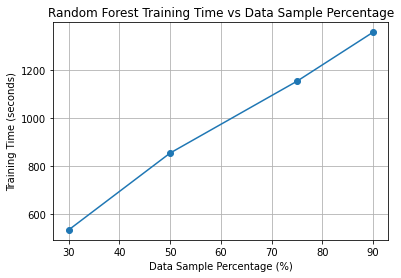

In [0]:
import matplotlib.pyplot as plt
t30 = 534.85  
t50 = 854.10   
t75 = 1152.32   
t90 = 1355.86   

data_pct   = [30, 50, 75, 90]
train_time = [t30, t50, t75, t90]

plt.figure()
plt.plot(data_pct, train_time, marker='o')
plt.xlabel("Data Sample Percentage (%)")
plt.ylabel("Training Time (seconds)")
plt.title("Random Forest Training Time vs Data Sample Percentage")
plt.grid(True)
plt.show()


In [0]:
#Isolation Forest

In [0]:
import time
import numpy as np
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler
)
from pyspark.ml import Pipeline
from sklearn.ensemble import IsolationForest as SklearnIF

# 1) Load and preprocess raw data
df_raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True,
    inferSchema=True
)
df = (
    df_raw
    .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
    .withColumn("deltaOrig", col("oldbalanceOrg") - col("newbalanceOrig"))
    .withColumn("deltaDest", col("newbalanceDest") - col("oldbalanceDest"))
    .withColumn("amount_to_orig_ratio", col("amount") / (col("oldbalanceOrg") + 1))
    .withColumn("amount_to_dest_ratio", col("amount") / (col("oldbalanceDest") + 1))
)

# 2) Build a preprocessing pipeline: index → one-hot → assemble → scale
si        = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
ohe       = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
assembler = VectorAssembler(
    inputCols=[
        'amount', 'oldbalanceOrg', 'newbalanceOrig',
        'oldbalanceDest', 'newbalanceDest',
        'deltaOrig', 'deltaDest',
        'amount_to_orig_ratio', 'amount_to_dest_ratio',
        'type_vec'
    ],
    outputCol="rawFeatures"
)
scaler    = StandardScaler(
    inputCol="rawFeatures",
    outputCol="features",
    withStd=True,
    withMean=False
)

pipeline_pre = Pipeline(stages=[si, ohe, assembler, scaler])
df_feat      = pipeline_pre.fit(df).transform(df)

# 3) Stratified sample (50%) then 80/20 train-test split
sample = df_feat.stat.sampleBy("isFraud", {0: 0.5, 1: 0.5}, seed=2025)
train, test = sample.randomSplit([0.8, 0.2], seed=2025)

# 4) Convert VectorUDT → ArrayType(Double) so Arrow can serialize
train2    = train.withColumn("feat_arr", vector_to_array("features"))
pdf_train = train2.select("feat_arr").toPandas()  # Arrow will succeed
X_train   = np.vstack(pdf_train["feat_arr"].to_numpy())

# 5) Train sklearn IsolationForest
iso = SklearnIF(
    n_estimators=100,
    contamination=0.001,
    max_samples="auto",
    random_state=42
)
start = time.time()
iso.fit(X_train)
print(f"IsolationForest train time: {time.time() - start:.2f} sec")

# 6) Determine anomaly threshold
train_scores = -iso.decision_function(X_train)
threshold    = np.percentile(train_scores, 100 * (1 - iso.contamination))

# 7) Broadcast for Spark-side scoring
b_iso    = spark.sparkContext.broadcast(iso)
b_thresh = spark.sparkContext.broadcast(threshold)


IsolationForest train time: 147.30 sec


In [0]:
from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import DoubleType, IntegerType
import pandas as pd
import numpy as np

# 1) make sure 'features' is an ArrayType(Double) so Arrow can ship it
from pyspark.ml.functions import vector_to_array
test2 = test.withColumn("feat_arr", vector_to_array("features"))

# 2) batch-score UDF
@pandas_udf(DoubleType())
def score_udf(vs: pd.Series) -> pd.Series:
    # vs is a Series of lists-of-floats
    arr = np.vstack(vs.to_numpy())
    return pd.Series(-b_iso.value.decision_function(arr))

# 3) batch-predict UDF
@pandas_udf(IntegerType())
def predict_udf(scores: pd.Series) -> pd.Series:
    return (scores > b_thresh.value).astype(int)

# 4) apply them
test_scored = (
    test2
      .withColumn("anomaly_score", score_udf(col("feat_arr")))
      .withColumn("prediction",   predict_udf(col("anomaly_score")))
)

test_scored.select("anomaly_score", "prediction", "isFraud").show(10, False)


+--------------------+----------+-------+
|anomaly_score       |prediction|isFraud|
+--------------------+----------+-------+
|-0.27079930973457916|0         |0      |
|-0.25205633996456955|0         |0      |
|-0.23443739669830027|0         |0      |
|-0.3292229829940235 |0         |0      |
|-0.31658483393002945|0         |0      |
|-0.3099796872605338 |0         |0      |
|-0.3261235515174455 |0         |0      |
|-0.14060036697118283|0         |0      |
|-0.20000351480318124|0         |0      |
|-0.2462231679834032 |0         |0      |
+--------------------+----------+-------+
only showing top 10 rows



In [0]:
# Cell 3: Compute evaluation metrics

# 1) Collect your Spark predictions into pandas
pdf_results = test_scored.select("prediction", "isFraud").toPandas()

# 2) Extract numpy arrays
y_pred = pdf_results["prediction"].values
y_true = pdf_results["isFraud"].values

# 3) Compute metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc    = accuracy_score(y_true, y_pred)
cm     = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=4)

# 4) Print results
print(f"Accuracy: {acc:.4f}\n")
print("Confusion Matrix:")
print(cm, "\n")
print("Classification Report:")
print(report)


Accuracy: 0.9978

Confusion Matrix:
[[634806    621]
 [   783     18]] 

Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9990    0.9989    635427
           1     0.0282    0.0225    0.0250       801

    accuracy                         0.9978    636228
   macro avg     0.5135    0.5107    0.5119    636228
weighted avg     0.9975    0.9978    0.9977    636228



In [0]:
import time
import numpy as np
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder,
    VectorAssembler, StandardScaler
)
from pyspark.ml import Pipeline
from sklearn.ensemble import IsolationForest as SklearnIF

# 1) Preprocessing pipeline (same as before)
df_raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True, inferSchema=True
)
df = (
    df_raw
    .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
    .withColumn("deltaOrig", col("oldbalanceOrg") - col("newbalanceOrig"))
    .withColumn("deltaDest", col("newbalanceDest") - col("oldbalanceDest"))
    .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
    .withColumn("amount_to_dest_ratio", col("amount")/(col("oldbalanceDest")+1))
)

si        = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
ohe       = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
assembler = VectorAssembler(
    inputCols=[
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest',
      'deltaOrig','deltaDest',
      'amount_to_orig_ratio','amount_to_dest_ratio',
      'type_vec'
    ],
    outputCol="rawFeatures"
)
scaler    = StandardScaler(inputCol="rawFeatures", outputCol="features",
                            withStd=True, withMean=False)

pipeline_pre = Pipeline(stages=[si, ohe, assembler, scaler])
df_feat      = pipeline_pre.fit(df).transform(df)

# 2) **Stratified 30% sample**, then 80/20 train/test split
sample30 = df_feat.stat.sampleBy("isFraud", {0: 0.3, 1: 0.3}, seed=2025)
train30, test30 = sample30.randomSplit([0.8, 0.2], seed=2025)

# 3) Convert VectorUDT → ArrayType so Arrow can serialize, collect into pandas
train30_arr = train30.withColumn("feat_arr", vector_to_array("features"))
pdf_train30 = train30_arr.select("feat_arr").toPandas()
X_train30   = np.vstack(pdf_train30["feat_arr"].to_numpy())

# 4) Train sklearn IsolationForest on your 30% sample
iso30 = SklearnIF(
    n_estimators=100,
    contamination=0.001,   # or tune to 0.01 if your true fraud rate is ~1%
    max_samples="auto",
    random_state=42
)
start = time.time()
iso30.fit(X_train30)
print(f"30%‐sample IsolationForest train time: {time.time() - start:.2f} sec")

# 5) Threshold & broadcast (for downstream Spark scoring)
train_scores30 = -iso30.decision_function(X_train30)
threshold30    = np.percentile(train_scores30, 100 * (1 - iso30.contamination))
b_iso30        = spark.sparkContext.broadcast(iso30)
b_thresh30     = spark.sparkContext.broadcast(threshold30)


30%‐sample IsolationForest train time: 95.29 sec


In [0]:
# Cell 2 — SCORE & EVALUATE ON 30% SAMPLE

from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import DoubleType, IntegerType
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Convert features to primitive array for Arrow
test30_arr = test30.withColumn("feat_arr", vector_to_array("features"))

# 2) Define vectorized (Pandas) UDFs for scoring & prediction
@pandas_udf(DoubleType())
def score_udf(vs: pd.Series) -> pd.Series:
    arr = np.vstack(vs.to_numpy())
    # sklearn decision_function: higher = more “normal”, so negate
    return pd.Series(-b_iso30.value.decision_function(arr))

@pandas_udf(IntegerType())
def predict_udf(scores: pd.Series) -> pd.Series:
    return (scores > b_thresh30.value).astype(int)

# 3) Apply UDFs to get anomaly scores & binary predictions
test_scored30 = (
    test30_arr
      .withColumn("anomaly_score", score_udf(col("feat_arr")))
      .withColumn("prediction",    predict_udf(col("anomaly_score")))
)

# 4) Collect results to pandas for metric computation
pdf_results30 = test_scored30.select("prediction", "isFraud").toPandas()
y_pred30 = pdf_results30["prediction"].values
y_true30 = pdf_results30["isFraud"].values

# 5) Compute & print classification metrics
acc    = accuracy_score(y_true30, y_pred30)
cm     = confusion_matrix(y_true30, y_pred30)
report = classification_report(y_true30, y_pred30, digits=4)

print(f"Accuracy: {acc:.4f}\n")
print("Confusion Matrix:")
print(cm, "\n")
print("Classification Report:")
print(report)


Accuracy: 0.9980

Confusion Matrix:
[[380759    362]
 [   419     12]] 

Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9991    0.9990    381121
           1     0.0321    0.0278    0.0298       431

    accuracy                         0.9980    381552
   macro avg     0.5155    0.5134    0.5144    381552
weighted avg     0.9978    0.9980    0.9979    381552



In [0]:
# Cell 1 — PREPROCESS & TRAIN IsolationForest on 75% SAMPLE

import time
import numpy as np
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder,
    VectorAssembler, StandardScaler
)
from pyspark.ml import Pipeline
from sklearn.ensemble import IsolationForest as SklearnIF

# 1) Load and preprocess raw data
df_raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True, inferSchema=True
)
df = (
    df_raw
    .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
    .withColumn("deltaOrig", col("oldbalanceOrg") - col("newbalanceOrig"))
    .withColumn("deltaDest", col("newbalanceDest") - col("oldbalanceDest"))
    .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
    .withColumn("amount_to_dest_ratio",  col("amount")/(col("oldbalanceDest")+1))
)

# 2) Build preprocessing pipeline (index → one-hot → assemble → scale)
si         = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
ohe        = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
assembler  = VectorAssembler(
    inputCols=[
        'amount','oldbalanceOrg','newbalanceOrig',
        'oldbalanceDest','newbalanceDest',
        'deltaOrig','deltaDest',
        'amount_to_orig_ratio','amount_to_dest_ratio',
        'type_vec'
    ],
    outputCol="rawFeatures"
)
scaler     = StandardScaler(inputCol="rawFeatures", outputCol="features",
                            withStd=True, withMean=False)
pipeline_pre = Pipeline(stages=[si, ohe, assembler, scaler])
df_feat      = pipeline_pre.fit(df).transform(df)

# 3) Stratified 75% sample and then 80/20 train/test split
sample75 = df_feat.stat.sampleBy("isFraud", {0: 0.75, 1: 0.75}, seed=2025)
train75, test75 = sample75.randomSplit([0.8, 0.2], seed=2025)

# 4) Convert VectorUDT → ArrayType so Arrow can serialize, collect into pandas
train75_arr = train75.withColumn("feat_arr", vector_to_array("features"))
pdf_train75 = train75_arr.select("feat_arr").toPandas()
X_train75   = np.vstack(pdf_train75["feat_arr"].to_numpy())

# 5) Train sklearn IsolationForest on 75% sample
iso75 = SklearnIF(
    n_estimators=100,
    contamination=0.001,    # adjust if your anomaly rate differs
    max_samples="auto",
    random_state=42
)
start = time.time()
iso75.fit(X_train75)
print(f"75%‐sample IsolationForest train time: {time.time() - start:.2f} sec")

# 6) Determine threshold & broadcast for Spark scoring
train_scores75 = -iso75.decision_function(X_train75)
threshold75    = np.percentile(train_scores75, 100 * (1 - iso75.contamination))
b_iso75        = spark.sparkContext.broadcast(iso75)
b_thresh75     = spark.sparkContext.broadcast(threshold75)


75%‐sample IsolationForest train time: 253.09 sec


In [0]:
# Cell 2 — SCORE & EVALUATE ON 75% SAMPLE

from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.functions import vector_to_array
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Convert features to primitive array for Arrow
test75_arr = test75.withColumn("feat_arr", vector_to_array("features"))

# 2) Define vectorized UDFs for scoring & prediction
@pandas_udf(DoubleType())
def score_udf(vs: pd.Series) -> pd.Series:
    arr = np.vstack(vs.to_numpy())
    # sklearn’s decision_function: higher = more “normal”, so negate for anomaly
    return pd.Series(-b_iso75.value.decision_function(arr))

@pandas_udf(IntegerType())
def predict_udf(scores: pd.Series) -> pd.Series:
    return (scores > b_thresh75.value).astype(int)

# 3) Apply UDFs to get anomaly scores & binary predictions
test_scored75 = (
    test75_arr
      .withColumn("anomaly_score", score_udf(col("feat_arr")))
      .withColumn("prediction",    predict_udf(col("anomaly_score")))
)

# 4) Collect results to pandas for metric computation
pdf_results75 = test_scored75.select("prediction", "isFraud").toPandas()
y_pred75 = pdf_results75["prediction"].values
y_true75 = pdf_results75["isFraud"].values

# 5) Compute & print classification metrics
acc75    = accuracy_score(y_true75, y_pred75)
cm75     = confusion_matrix(y_true75, y_pred75)
report75 = classification_report(y_true75, y_pred75, digits=4)

print(f"Accuracy: {acc75:.4f}\n")
print("Confusion Matrix:")
print(cm75, "\n")
print("Classification Report:")
print(report75)


Accuracy: 0.9978

Confusion Matrix:
[[952576    929]
 [  1214     83]] 

Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9990    0.9989    953505
           1     0.0820    0.0640    0.0719      1297

    accuracy                         0.9978    954802
   macro avg     0.5404    0.5315    0.5354    954802
weighted avg     0.9975    0.9978    0.9976    954802



In [0]:
# Cell 1 — PREPROCESS & TRAIN IsolationForest on 90% SAMPLE

import time
import numpy as np
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder,
    VectorAssembler, StandardScaler
)
from pyspark.ml import Pipeline
from sklearn.ensemble import IsolationForest as SklearnIF

# 1) Load and preprocess raw data
df_raw = spark.read.csv(
    "/FileStore/tables/Synthetic_Financial_datasets_log.csv",
    header=True, inferSchema=True
)
df = (
    df_raw
    .drop("nameOrig", "nameDest", "isFlaggedFraud", "step")
    .withColumn("deltaOrig", col("oldbalanceOrg") - col("newbalanceOrig"))
    .withColumn("deltaDest", col("newbalanceDest") - col("oldbalanceDest"))
    .withColumn("amount_to_orig_ratio", col("amount")/(col("oldbalanceOrg")+1))
    .withColumn("amount_to_dest_ratio", col("amount")/(col("oldbalanceDest")+1))
)

# 2) Build preprocessing pipeline (index → one-hot → assemble → scale)
si         = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
ohe        = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"])
assembler  = VectorAssembler(
    inputCols=[
        'amount','oldbalanceOrg','newbalanceOrig',
        'oldbalanceDest','newbalanceDest',
        'deltaOrig','deltaDest',
        'amount_to_orig_ratio','amount_to_dest_ratio',
        'type_vec'
    ],
    outputCol="rawFeatures"
)
scaler     = StandardScaler(inputCol="rawFeatures", outputCol="features",
                            withStd=True, withMean=False)
pipeline_pre = Pipeline(stages=[si, ohe, assembler, scaler])
df_feat      = pipeline_pre.fit(df).transform(df)

# 3) Stratified 90% sample, then 80/20 train/test split
sample90 = df_feat.stat.sampleBy("isFraud", {0: 0.9, 1: 0.9}, seed=2025)
train90, test90 = sample90.randomSplit([0.8, 0.2], seed=2025)

# 4) Convert features and collect into pandas
train90_arr = train90.withColumn("feat_arr", vector_to_array("features"))
pdf_train90 = train90_arr.select("feat_arr").toPandas()
X_train90   = np.vstack(pdf_train90["feat_arr"].to_numpy())

# 5) Train sklearn IsolationForest on 90% sample
iso90 = SklearnIF(
    n_estimators=100,
    contamination=0.001,    # adjust to your true anomaly rate
    max_samples="auto",
    random_state=42
)
start = time.time()
iso90.fit(X_train90)
print(f"90%-sample IsolationForest train time: {time.time() - start:.2f} sec")

# 6) Determine threshold & broadcast for downstream scoring
train_scores90 = -iso90.decision_function(X_train90)
threshold90    = np.percentile(train_scores90, 100 * (1 - iso90.contamination))
b_iso90        = spark.sparkContext.broadcast(iso90)
b_thresh90     = spark.sparkContext.broadcast(threshold90)


90%-sample IsolationForest train time: 294.41 sec


In [0]:
# Cell 2 — SCORE & EVALUATE ON 90% SAMPLE

from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.functions import vector_to_array
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Convert features to primitive array for Arrow
test90_arr = test90.withColumn("feat_arr", vector_to_array("features"))

# 2) Define Pandas UDFs for scoring & prediction
@pandas_udf(DoubleType())
def score_udf(vs: pd.Series) -> pd.Series:
    arr = np.vstack(vs.to_numpy())
    # sklearn decision_function: higher = more “normal”, so negate for anomaly
    return pd.Series(-b_iso90.value.decision_function(arr))

@pandas_udf(IntegerType())
def predict_udf(scores: pd.Series) -> pd.Series:
    return (scores > b_thresh90.value).astype(int)

# 3) Apply UDFs to get anomaly scores & binary predictions
test_scored90 = (
    test90_arr
      .withColumn("anomaly_score", score_udf(col("feat_arr")))
      .withColumn("prediction",    predict_udf(col("anomaly_score")))
)

# 4) Collect results to pandas for metric computation
pdf_results90 = test_scored90.select("prediction", "isFraud").toPandas()
y_pred90 = pdf_results90["prediction"].values
y_true90 = pdf_results90["isFraud"].values

# 5) Compute & print classification metrics
acc90    = accuracy_score(y_true90, y_pred90)
cm90     = confusion_matrix(y_true90, y_pred90)
report90 = classification_report(y_true90, y_pred90, digits=4)

print(f"Accuracy: {acc90:.4f}\n")
print("Confusion Matrix:")
print(cm90, "\n")
print("Classification Report:")
print(report90)


Accuracy: 0.9978

Confusion Matrix:
[[1142944    1084]
 [   1404      74]] 

Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9991    0.9989   1144028
           1     0.0639    0.0501    0.0561      1478

    accuracy                         0.9978   1145506
   macro avg     0.5313    0.5246    0.5275   1145506
weighted avg     0.9976    0.9978    0.9977   1145506



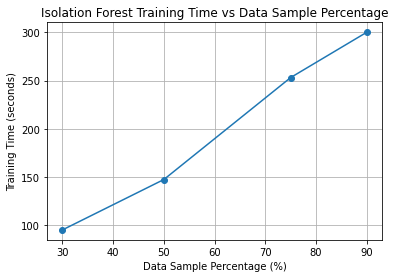

In [0]:
import matplotlib.pyplot as plt
t30 =  95.29
t50 =  147.50
t75 =  253.09
t90 =  300

data_pct   = [30, 50, 75, 90]
train_time = [t30, t50, t75, t90]

plt.figure()
plt.plot(data_pct, train_time, marker='o')
plt.xlabel("Data Sample Percentage (%)")
plt.ylabel("Training Time (seconds)")
plt.title("Isolation Forest Training Time vs Data Sample Percentage")
plt.grid(True)
plt.show()
